## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#conclusion)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
np.random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('data/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
print(f'number of rows: {df.shape[0]}')

number of rows: 294478


c. The number of unique users in the dataset.

In [4]:
print(f'number of unique users: {df.user_id.nunique()}')

number of unique users: 290584


d. The proportion of users converted.

In [5]:
#Proportion of users converted are the number of users with 1 divided by the total number of users
#and since the variable is binary we can just do the mean
print(f'The proportion of users converted: {df.converted.mean()*100:.2f}%')

The proportion of users converted: 11.97%


e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
#The statement above means the number of times where: control/new_page line up or treatement/old_page line up
query = df.query('(group == "treatment" & landing_page != "new_page") | (group != "treatment" & landing_page == "new_page")')

print(f'The number of times new_page and treatment don\'t line up: {len(query)}')

The number of times new_page and treatment don't line up: 3893


f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
#remove non matching pairs of treatment/new_page by dropping idx of previous query
df2 = df.drop(query.index)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
print(f'number of unique users: {df2.user_id.nunique()}')

number of unique users: 290584


b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2.user_id[df2.user_id.duplicated()]

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
dup = df2[df2.user_id.duplicated()]
dup

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.drop(dup.index, inplace=True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
# p(converted)
df2.converted.mean().round(4)

0.1196

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
# p(converted|control)
df2[df2.group == 'control'].converted.mean().round(4)

0.1204

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
# p(converted|treatment)
df2[df2.group == 'treatment'].converted.mean().round(4)

0.1188

d. What is the probability that an individual received the new page?

In [17]:
"""
factorize() does the label encoding of the landing_page categorical variables: old_page = 0 / new_page = 1
df2.landing_page.factorize() -- > (array([0, 0, 1, ..., 0, 0, 1]),
                                  Index(['old_page', 'new_page'], dtype='object'))
"""
# p(new_page)
df2.landing_page.factorize()[0].mean().round(4)

0.5001

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Given the above probabilities, there is no sufficient evidence to assume that the new page leads to more conversions even though that the probabilities are low enough to have a biased opinion**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

 $$Null: 𝑝𝑛𝑒𝑤-𝑝𝑜𝑙𝑑\leq0 $$

 $$Alternative: 𝑝𝑛𝑒𝑤-𝑝𝑜𝑙𝑑>0 $$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
p_new = df2.converted.mean().round(4)
p_new

0.1196

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old = df2.converted.mean().round(4)
p_old

0.1196

c. What is $n_{new}$?

In [20]:
n_new = 145310

d. What is $n_{old}$?

In [21]:
n_old = 145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.binomial(1, p_new, n_new)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.binomial(1, p_old, n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
diff = new_page_converted.mean() - old_page_converted.mean()
diff

-0.002397302297957274

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [25]:
%%time
p_diffs = list()
for _ in range(10000):
    npc = np.random.binomial(1, p_new, n_new)
    opc = np.random.binomial(1, p_old, n_old)
    diff = npc.mean() - opc.mean()
    p_diffs.append(diff)
p_diffs = np.asarray(p_diffs)

CPU times: user 35.4 s, sys: 0 ns, total: 35.4 s
Wall time: 35.4 s


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

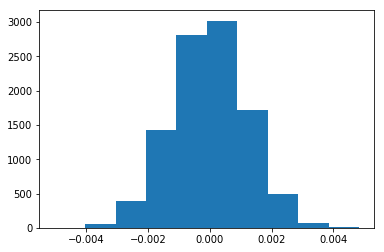

In [26]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
pval = (p_diffs>diff).mean()
pval

0.9003

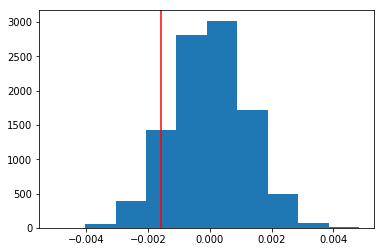

In [28]:
plt.hist(p_diffs);
plt.axvline(diff, c='r');

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

In part j. we computed the **p-value** (which is the probability that the observed statistic comes from the null) using the bootstrapping technique to simulate the sampling distribution. Since our **p-value > α**, we can conclude that the resulting distribution comes from the null, thus we **fail to reject the null**.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = p_old
convert_new = p_new
n_old = n_old
n_new = n_new

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [30]:
stat, pval = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old],alternative='larger')

In [31]:
pval

0.500024172503866

In [32]:
stat

-6.059148169611522e-05

[source](https://stats.stackexchange.com/questions/329465/assessing-a-b-test-results-using-python)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.**

>This uses a simple normal test for proportions. It should be the same as running the mean z-test on the data encoded 1 for event and 0 for no event so that the sum corresponds to the count.

The above statement is from the documentation of proportions_ztest, I did not find the exact p-value as the above question but **they're both bigger than α which lead to the same conclusion (Fail to reject the null)**.The returned **zstat** tells us that the number that is representing how many standard deviations are above or below the mean population score is ≃ to 0 which is population mean difference

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Since our dependendant variable is binary we have to use **logistic regression** to predict the outcome of each individual.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [33]:
#create copy to work on
df3 = df2.copy()

#add intercept column
df3['intercept'] = 1

#create landin_page dummies
df3[['old_page', 'new_page']] = pd.get_dummies(df3.landing_page)

#create label encoded group column
df3['ab_page'] = df3.group.factorize()[0]

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [64]:
#init logistic regression model
log_model = sm.Logit(df3.converted, df3[['intercept', 'ab_page', 'new_page']])
res = log_model.fit()

         Current function value: 0.366118
         Iterations: 35


/home/zowlex/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


`d.` Provide the summary of your model below, and use it as necessary to answer the following questions.

In [65]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 11 May 2020   Pseudo R-squ.:               8.077e-06
Time:                        15:05:29   Log-Likelihood:            -1.0639e+05
converged:                      False   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.3308   1.26e+05  -1.05e-05      1.000   -2.48e+05    2.48e+05
ab_page       -0.6729   1.26e+05  -5.32e-06      1.000   -2.48e+05    2.48e+05
new_page      -0.6579   1.26e+05   -5.2e-06      1.000   -2.48e+05    2.48e+05
==============================================================================
"""

`e.` What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p-value associated with **ab_page** = 1 which is greater than the values from part II. The difference between both parts is that in the first method we're trying to make conclusions about a population while when using logistic regression we are trying to make conclusions about each individual where the null is **there's no relationship between X and y** and we test whether adding each of the features does not improve the equation anymore

`f.` Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Adding other factors into our regression model is a good idea as long as these features are linearly independent and in return it will lead to a more expressive model

`g.` Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [99]:
countries_df = pd.read_csv('data/countries.csv')
df_new = countries_df.set_index('user_id').join(df3.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,old_page,new_page,ab_page
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


In [100]:
#get country unique values
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [101]:
### Create the necessary dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new.country)

X = df_new[['intercept', 'new_page', 'UK', 'US']]
y = df_new.converted

#### statmodels Logit

In [111]:
def log_model(X, y):
    """
    perform logistic regression from statmodels on Variables X y
    output: model result
    """
    model = sm.Logit(y, X)
    res = model.fit()
    return res

In [89]:
res = log_model(X, y)
res

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [90]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 May 2020   Pseudo R-squ.:               2.323e-05
Time:                        16:03:49   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0450      0.027    -76.820      0.000      -2.097      -1.993
new_page       0.0149      0.011      1.307      0.191      -0.007       0.037
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

#### scikit learn LogisticRegression 

In [91]:
log_reg = LogisticRegression(fit_intercept=False)
log_reg.fit(X, y)

res1 = log_reg.coef_
res1

array([[-2.04349976,  0.01481766,  0.0492164 ,  0.03934758]])

We got the same results with sklearn's LogisticRegression model where:
      - Intercept : is the log(odds) for converted=0
      - new_page : is the log(odds ratio) that tells us on a log scale how much having received the new page   increases or decreases the odds of converting

[Source](https://www.youtube.com/watch?v=vN5cNN2-HWE)

### Result interpretation

In [92]:
#get the exponential values to interpret results
np.exp(res.params)

intercept    0.129384
new_page     1.015056
UK           1.051944
US           1.041599
dtype: float64

- If an individual received the **new_page**, they are 1.015056 times more likely to convert than if they received the **old_page** holding all other variables constant.

- If an individual is from **UK**, they are 1.051944 times more likely to convert than an individual from **CA** holding all other variables constant.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [102]:
### Fit Your Linear Model And Obtain the Results

#create interaction between page and country
df_new['country_page'] = df_new.country + '_' + df_new.landing_page

#create dummy variables
df_new = df_new.join(pd.get_dummies(df_new.country_page))
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,old_page,new_page,ab_page,CA,UK,US,country_page,CA_new_page,CA_old_page,UK_new_page,UK_old_page,US_new_page,US_old_page
user_id,,,,,,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,0,1,0,UK_old_page,0,0,0,1,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0,0,1,US_new_page,0,0,0,0,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1,0,UK_new_page,0,0,1,0,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,0,1,0,UK_old_page,0,0,0,1,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1,0,UK_new_page,0,0,1,0,0,0


In [104]:
X = df_new[['intercept', 'CA_new_page', 'UK_new_page', 'US_new_page']]
y = df_new.converted

res = log_model(X, y)
res.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 May 2020   Pseudo R-squ.:               3.351e-05
Time:                        16:19:09   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                   0.06785
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -1.9888      0.008   -246.669      0.000      -2.005      -1.973
CA_new_page    -0.0827      0.038     -2.176      0.030      -0.157      -0.008
UK_new_page     0.0074      0.018      0.410      0.682      -0.028       0.043
US_new_page    -0.0183      0.013     -1.449      0.147      -0.043       0.006
===============================================================================
"""

- A user from CA or US who received the new_page is less likely to convert
- A user from UK who received a new_page is more likely to convert

<a id='conclusion'></a>
## Conclusions 
    
   - Calculating probabilities gave us an intuition about the direction where this A/B test is going but cannot confirm it which lead to perform Hypothesis testing.
   - Results from the hypothesis test suggest that we **fail to reject the null:** $$pnew-pold<0$$ 
   - Given that our dependent variable is binary (0 for not converted and 1 for converted) we have to apply logistic regression as our linear model.
   - Difference between Hypothesis testing and Logistic regression:
       - Hypothesis testing is made to draw conclusions about a population
       - Logistic regression (in our case) is made to draw conclusions about each individual
   - Additional features seem to make our model more exprssive as long as they are linearly independent.